#Imports

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [4]:
from Fcns.activR5HTtoHA import *
from Fcns.allo_ssri_ki import *
from Fcns.degran_ha_mc import *
from Fcns.fireha import *
from Fcns.fireht import *
from Fcns.inj import *
from Fcns.H1ha import *
from Fcns.H1ht import *
from Fcns.HTDCin import *
from Fcns.inhibR5HTto5HT import *
from Fcns.inhibRHAto5HT import *
from Fcns.inhibRHAtoHA import *
from Fcns.inhibsyn5HTto5HT import *
from Fcns.inhibsynHAtoHA import *
from Fcns.k_5ht1ab_rel_ps import *
from Fcns.k_5ht1ab_rel_sp import *
from Fcns.k_fmh_inh import *
from Fcns.k_ssri_reupt import *
from Fcns.mc_activation import *
from Fcns.TCcatab import *
from Fcns.VAADC import *
from Fcns.VDRR import *
from Fcns.vha_trafficking import *
from Fcns.VHAT import *
from Fcns.VHATg import *
from Fcns.VHATmc import *
from Fcns.VHNMT import *
from Fcns.VHNMTg import *
from Fcns.VHNMTmc import *
from Fcns.vht_trafficking import *
from Fcns.VHTDC import *
from Fcns.VHTDCg import *
from Fcns.VHTDCmc import *
from Fcns.VHTL import *
from Fcns.VHTLg import *
from Fcns.VHTLmc import *
from Fcns.VMAT import *
from Fcns.VMATH import *
from Fcns.VMATHmc import *
from Fcns.VPOOL import *
from Fcns.VSERT import *
from Fcns.VTPH import *
from Fcns.VTRPin import *
from Fcns.VUP2 import *
from Fcns.inhib_NMDA import *

# Definitions

In [322]:
#Define constants
t_max = 1001 #max simulation time in ms

NE = 800
NI = 200
N = NE + NI

re = np.random.rand(NE)
ri = np.random.rand(NI)

step_small = 0.5
step_large = 1

step_large_hconverted = step_large / 1000 / 60 / 60

a1 = (13) #Weight of excitatory AMPA inputs.
a2 = (3) #Weight of inhibitory GABA A inputs.
a3 = (80) * 1000 #Weight of excitatory NMDA inputs.
a4 = (1.5) #Weight of inhibitory GABA B inputs.
a5 = 2.5 #Rate of production of neurotransmitter per spike (ms-1).
a6 = 0.2 #Rate of reuptake of neurotransmitter (ms-1).
a7 = 0.1 #Rate of increase of excitatory w_fast (AMPA) from neurotransmitter presence (ms-1).
a8 = 0.2 #Rate of decrease of excitatory w_fast (AMPA) (ms-1).

a9 = 0.03 #Rate of increase of inhibitory w_fast (GABA A) from neurotransmitter presence (ms-1).
a10 = 0.1 #Rate of decrease of inhibitory w_fast (GABA A) (ms-1).

a11 = 0.025 #Rate of increase of excitatory w_slow (NMDA) from neurotransmitter presence (ms-1).
a12 = 0.020 #Rate of decrease of excitatory w_slow (NMDA) (ms-1).

a13 = 0.001 #Rate of increase of inhibitory w_slow (GABA B) from neurotransmitter presence (ms-1).
a14 = 0.001 #Rate of decrease of inhibitory w_slow(GABA B) from neurotransmitter presence (ms-1).

a15 = 0.01 #Rate of increase of neuron activity from individual spike (ms-1).
a16 = 0.0001 #Rate of decrease of neuron activity if neuron does not spike (ms-1).

a = np.concatenate((0.02 * np.ones(NE), 0.02 + 0.08 * ri), dtype=np.float16) #time scale of recovery variable u
b = np.concatenate((0.2 * np.ones(NE), 0.25 - 0.05 * ri), dtype=np.float16) #sensitivity of recovery variable u
c = np.concatenate((-65 + 15 * np.square(re), -65 * np.ones(NI)), dtype=np.float16) # after spike reset value of membrane potential
d = np.concatenate((8 - 6 * np.square(re), 2 * np.ones(NI)), dtype=np.float16) # after spike reset of recovery variable u

NMDA_dependency = np.ones(N)
NMDA_dependency[:NE] = 0.1
NMDA_dependency[NE:] = 1

R = 8.31 #J*K^-1*mol^-1
T = 273 #K
F = 96485 #C*mol^-1
normal = 4/155 # normal physiological extra_k+/intra_k+ ratio

E_normal = R*T/F*np.log(normal)

In [323]:
#Define variables

#Connectivity matrix
C = np.concatenate((0.5 * np.random.rand(NE, N), np.random.rand(NI, N)), axis=0, dtype=np.float16)

transmitter_acc = np.zeros(N, dtype=np.float16) # neurotransmitter concentrations
w_fast = np.zeros(N, dtype=np.float16) # fast receptor weights for AMPA and GABA_A
w_slow = np.zeros(N, dtype=np.float16) # slow receptor weights for NMDA and GABA_B

w_fast_delta = np.zeros(N, dtype=np.float16)
w_slow_delta = np.zeros(N, dtype=np.float16)


v = -65 * np.ones(NE + NI, dtype=np.float16)  # Initial values of v
u = b * v  # Initial values of u
firings = []  # spike timings
AMPA_conductances = np.zeros((t_max, N), dtype=np.float16)
NMDA_conductances = np.zeros((t_max, N), dtype=np.float16)
transmitter_acc_over_time = np.zeros((t_max, N), dtype=np.float16)
membrane_voltages = np.zeros((t_max, N), dtype=np.float16) - 65
activity_state = np.zeros(N, dtype=np.float16) # morphogentic states (high/low)
cai = np.zeros((t_max, N), dtype=np.float16) # internal calcium

bdnf_c = 0.5 * np.ones(N, dtype=np.float16) # extracellular BDNF concentration around every cell
pro_bdnf_c = 0.5 * np.zeros(N, dtype=np.float16) # extracellular pro-BDNF concentration around every cell
c_kplus_e = 4 * np.ones(N, dtype=np.float16) # extracellular k+ in mM concentration around every cell
c_kplus_i = 155 * np.ones(N, dtype=np.float16) # intracellular k+ in mM concentration around every cell
recent_spike = np.zeros(N, dtype=np.float16) - np.inf # most recent spike for cell, detremines start of diffusion for released K+
trkb_binding = np.zeros(N, dtype=np.float16) # TrKB recptor for m-BDNF
pn75NTRR_binding = np.zeros(N, dtype=np.float16) # pn75NTRR recptor for pro-BDNF (precursor of m-BDNF)
CaMKII_binding = np.zeros(N, dtype=np.float16) # Ca2+/Calmodoulin receptor
genesis_weights = np.concatenate((0.001 * np.ones(NE), -0.001 * np.ones(NI, dtype=np.float16)), dtype=np.float16) # synaptogenesis weights

In [324]:
# Set up comp_mpdel sert and hist ------------
t_factor = 3600 # Time factor for graphs.
v2 = 0.41 # in ml. brain volume

## Mast cell model of neuroinflammation.
mc_start_time = 0.5*3600/t_factor #Time to start neuroinflammation effects with mast cells.
mc_switch = 0 #Switch that turns on an off all effects of mast cell presence.

## Basal parameters.
btrp0 = 96 #Blood tryptophan equilibrium value.
eht_basal = 0.06 #Steady state basal concentration of serotonin.
gstar_5ht_basal = 0.8561 #Equilibrium concentration of g* serotonin.
gstar_ha_basal =  0.7484 #Equilibrium concentration of g* histamine.
bht0 = 100 # Blood histidine equilibrium value.
vht_basal = 63.0457 #Basal vesicular 5ht.
vha_basal = 136.3639 #Basal vesicular ha.


#Initial conditions
y0_sert = np.array([95.9766, 0.0994, 0.9006, 20.1618, 1.6094, 0.0373, 63.0383, 280.0048, 0.0603, 1.6824, 113.4099, 0.8660, 1.0112, 0.9791, 0.0027, 0.7114, 1.3245, 0.9874, 0.2666, 1.0203, 0.2297, 0, 3.1074, 136.3639, 241.9217, 1.4378, 2.0126, 99.7316, 249.3265, 311.6581, 0.7114, 1.3245, 0.9874, 0.8660, 1.0112, 0.9791, 354.6656, 177.3328,	350,	150,	3,	140])

#Get solution of the differential equation.

dy_sert = np.zeros(len(y0_sert))
y_sert = y0_sert

In [325]:
# Set up comp_mpdel for ketamine ----------

t_factor = 3600 # Time factor for graphs.
weight = 20                          # Mouse weight in g

#Dose parameters for ketamine.
ketamine_dose_factor = 10                     # mg/kg of body weight.
ketamine_start_time = 0*3600/t_factor           # Starting time of ketamine dose in same units as t_factor.
ketamine_dose = (ketamine_dose_factor*1e6)*(weight/1000) * 0.001 # In ug.
ketamine_repeat_time = 8*3600/t_factor #Time for repeat of dose.
ketamine_bioavailability = 0.8

#Molecular weight of escitalopram.
ketamine_molecular_weight = 237.725 #g/mol, or ug/umol.


#Initial conditions
y0_ket = [0, 0, 0, 0, 0, 0, 0]
y_ket = y0_ket

In [326]:
#Define dynamics

##Function of AMPA current (mA/cm^2).
def  I_AMPA(g_AMPA, Vm):
  E_AMPA = 0.0 #Reversal potential for AMPA channels (mV)
  return g_AMPA*(Vm - E_AMPA)

##Function of magnesium block of NMDA dependent on voltage (mV).
def MgB(Vm):
  Mg0 = 2 #mM
  return 1/(1 + (Mg0 * np.exp(-0.062*Vm))/3.57)


##Function of NMDA channel sodium current density (mA/cm^2).
def I_NMDA_Na(g_NMDA, Vm, inh_NMDA):
  P_Na = 1 #Permeability ratio to sodium.
  c = 0.1 #Conversor A/m^2 -> mA/cm^2
  P_NMDA = 10*10**(-9) #m/s
  F = 96485 #C/mol
  R = 8.314 #J/K*mol
  T = 308.15 #K
  Nai = 18 #mM
  Nao = 140 #mM
  V_lim = 100 #mV
  a1 = g_NMDA * c * P_NMDA * P_Na * MgB(Vm) * (2-inh_NMDA) * ((Vm/1000 * F**2)/(R*T))

  a2 = (Nai - Nao * np.exp(-((Vm/1000 * F)/(R*T))))/(1 - np.exp(-((Vm/1000 * F)/(R*T))))

  a2[Vm > V_lim] = Nai
  a2[Vm < -V_lim] = Nai

  I = a1*a2

  return I

##Function of NMDA channel potassium current density (mA/(cm^2 m-1))
def I_NMDA_K(g_NMDA, Vm, inh_NMDA):
  P_K = 1 #Permeability ratio to potassium.
  c = 0.1 #Conversor A/m^2 -> mA/cm^2
  P_NMDA = 10*10**(-9) #m/s
  F = 96485 #C/mol
  R = 8.314 #J/K*mol
  T = 308.15 #K
  Ki = 140 #mM
  Ko = 5 #mM
  V_lim = 100 #mV
  a1 = g_NMDA * c * P_NMDA * P_K * MgB(Vm) * (2-inh_NMDA) * ((Vm/1000 * F**2)/(R*T))
  a2 = (Ki - Ko * np.exp(-((Vm/1000 * F)/(R*T))))/(1 - np.exp(-((Vm/1000 * F)/(R*T))))
  a2[Vm > V_lim] = Ki
  a2[Vm < -V_lim] = Ko

  I = a1*a2

  return I


##Function of NMDA channel calcium current density (mA/cm^2).
def I_NMDA_Ca(g_NMDA, Vm, inh_NMDA):
  P_Ca = 10.6 #Permeability ratio to calcium.
  c = 0.1 #Conversor A/m^2 -> mA/cm^2
  P_NMDA = 10*10**(-9) #m/s
  F = 96485 #C/mol
  R = 8.314 #J/K*mol
  T = 308.15 #K
  Cai = 0.0001 #mM
  Cao = 2 #mM
  V_lim = 100 #mV
  a1 =  g_NMDA * c * P_NMDA * P_Ca * MgB(Vm) * (2-inh_NMDA) * ((4*Vm/1000 * F**2)/(R*T))
  a2 = Cai - Cao * np.exp(-((2*Vm/1000 * F)/(R*T)))/(1 - np.exp(-((2*Vm/1000 * F)/(R*T))))

  a2[Vm > V_lim] = Cai
  a2[Vm < -V_lim] = Cao

  I = a1*a2

  return I


##Function of total NMDA channel current density (mA/cm^2).
def I_NMDA(g_NMDA, Vm, inh_NMDA):
  return I_NMDA_Na(g_NMDA, Vm, inh_NMDA) + I_NMDA_K(g_NMDA, Vm, inh_NMDA) + I_NMDA_Ca(g_NMDA, Vm, inh_NMDA)


##Function of inward calcium rate (uM/ms).
def inward_Ca(g_NMDA, Vm, inh_NMDA, spikes):
  F = 96485 # Faraday Constant (mA*ms/umol).
  d = 8.4e-6 #Distance of membrane shell where calcium ions enter (cm).
  c = 1000 #conversor umol/(cm^3 * ms) to uM/ms.
  vdcc_caflux = 0.2

  return - c * I_NMDA_Ca(g_NMDA, Vm, inh_NMDA)/(2*F*d)/100 + spikes * vdcc_caflux

##Function of outward calcium rate (uM/ms).
def outward_Ca(Cai):
  Cai_eq = 0
  c = 0.1 #Rate of calcium pump buffering (ms^-1).
  return + c * (Cai - Cai_eq)

##Function of GABA A current (mA/cm^2).
def I_GABA_A(g_GABA_A, Vm):
  E_GABA_A = -70.0 #Reversal potential for GABA A channels (mV).
  return g_GABA_A * (Vm - E_GABA_A)

##Function of GABA B current (mA/cm^2).
def I_GABA_B(g_GABA_B, Vm):
  E_GABA_B = -95.0 #Reversal potential for GABA B channels (mV).
  return g_GABA_B*(Vm - E_GABA_B)/(1.0 + np.exp(-(Vm + 80.0)/25.0))

#Function that calculates g_AMPA, from AMPA input weights and connectivity weights.
def g_AMPA_calc(a1, C, w, N, NE):
  return a1 * np.dot(C[:NE, :].T, w[:NE])/NE

#Function that calculates g_GABA_A, from GABA A input weights and connectivity weights.
def g_GABA_A_calc(a2, C, w, N, NE):
  return a2 * np.dot(C[NE:, :].T, w[NE:])/(N-NE)

#Function that calculates g_NMDA, from NMDA input weights and connectivity weights.
def g_NMDA_calc(a3, C, w, N, NE):
  return a3 * np.dot(C[:NE, :].T, w[:NE])/NE

#Function that calculates g_GABA B, from GABA B input weights and connectivity weights.
def g_GABA_B_calc(a4, C, w, N, NE):
  return a4 * np.dot(C[NE:, :].T, w[NE:])/(N-NE)

def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

def delta_sigmoid(x):
  sig = sigmoid(x)
  return sig*(1-sig)

def connectivity_update(C, act, N, NE, weights):
    sigma = 0.5

    w = np.ones(N)
    w[:NE] = w[:NE] * -1 #Weight of update on excitatory plates.

    # C_old + Presynaptic update + Postsynaptic update
    C = C + (weights * (act - 0.5)).reshape(N,-1) + (act - 0.5) * (w * weights).reshape(N,-1)
    C = np.clip(C, 0, 1)

    return C

def bAP_signal(v, activity_state):
  bAP = np.zeros_like(activity_state)

  #slower than a constant threshold
  actvt_threshold = np.clip(np.random.rand(), 0.6, 1) #0.7

  actvt_threshold_reached = np.where(activity_state > actvt_threshold)[0]
  bAP_threshold_reached = np.where(v > 35)[0]
  bAP[bAP_threshold_reached] = 1
  bAP[actvt_threshold_reached] = 1

  return bAP

def CaMKII(ca_concentration, CaMKII_density = 1):
  K_H1 = 4 # The Ca2 activation Hill constant of CaMKII in uM
  F = (ca_concentration/K_H1)**4/(1 + ((ca_concentration/K_H1)**4))

  return F #fraction of CaMKII subunits bound to Ca+ /CaM

def TrkB(bdnf_concentration, trkb_density = 1):
  shift = -6
  return sigmoid(trkb_density * bdnf_concentration + shift)

def p75_NTR(bdnf_concentration, pro_bdnf_concentration, p75_NTR_density = 1):
  mBDNF_affinity = 0.1
  proBDNF_affinity = 1
  shift = -6

  return sigmoid(mBDNF_affinity * bdnf_concentration + proBDNF_affinity * pro_bdnf_concentration + shift)

def delta_bdnf(bAP_signals, g_AMPA, cai, bdnf_c, eht):
  bAP_weight = 0.1
  transmitter_weight = 0.1
  conductance_concentration_factor = 0.1
  calcium_weight = 0.1
  bdnf_reuptake = -0.1 # speed at which BDNF is reuptaken
  serotonin_weight = 0.1
  eht_basal = 0.06 #Steady state basal concentration of serotonin.

  release = bAP_weight * bAP_signals + transmitter_weight * (conductance_concentration_factor * g_AMPA) + calcium_weight * cai + serotonin_weight*(eht - eht_basal)
  reuptake = bdnf_c * bdnf_reuptake

  return release + reuptake

def pro_bdnf(bdnf_concentration):
  return 1 - bdnf_concentration

def delta_ext_k(spikes, c_kplus, t_since_active, t):
  decay_constant = -0.154
  dek = (spikes * 0.03) + (0.03 * decay_constant * np.exp(decay_constant * (t - t_since_active)))

  return dek

def delta_intra_k(d_e_k):
  vol_e_div_i = 5
  dik = -d_e_k * vol_e_div_i

  return dik

def synaptogenesis_weights(camkII, trkb, p75_ntr, activity_state):
  #recent activity frequency changes sign of CaMKII contribution
  factor = np.ones(N, dtype = np.float16)
  factor[np.where(activity_state < 0.5)[0]] = -1
  camkII = camkII * factor

  return sigmoid(camkII + trkb - p75_ntr)

def delta_resting_potential(concentration_ratio, t):
  R = 8.31 #J*K^-1*mol^-1
  T = 273 #K
  F = 96485 #C*mol^-1
  normal = 4/155 # normal physiological extra_k+/intra_k+ ratio

  E_current = R*T/F*np.log(concentration_ratio)
  delta_E = E_current - E_normal

  return delta_E

def fireDRN5ht(C, act, N):
  drn_input_vector = np.mean(C, axis= 1)
  a = np.dot(drn_input_vector, act)/N
  threshold = 0.1
  ht_release_factor = 0.1

  if a > threshold:
    return a * ht_release_factor
  else:
    return 0

##Function of occupacy ratio of NMDA receptors depending on ketamine and norketamine concentration (uM)
#This function assumes that k and nk don't inhibit each other, and that glutamate concentration has no effect on binding rate of k and nk, since their binding stregth is much greater.
def inhib_NMDA(k, nk):
  #Hill equation (MM non-competitive inhibition)
  #Not affected by glutamate concentration.
  n_k = 1.4 #Hill number ketamine.
  n_nk = 1.2 #Hill number nor-ketamine.
  Ki_k = 2 #Ketamine concentration for half occupacy (uM)
  Ki_nk = 17 #Norketamine concentration for half occupacy (uM)

  if k < 0.0001 or nk < 0.0001:
    return 0

  f = 1/(1 + (Ki_k/k)**n_k) + 1/(1 + (Ki_nk/nk)**n_nk)

  return f

def ketamine_inj(t, t_start, t_repeat, q):
  inj_time = 1/3600
  if t > t_start:
    n_stim = int((t - t_start)//t_repeat)
    if (t > (t_start + n_stim * t_repeat)) and (t <= (t_start + inj_time + n_stim * t_repeat)):
      f = q/inj_time
    else:
      f = 0
  else:
    f = 0
  return f

# Serotonin and Histamine Model

In [327]:
def comp_model_sert_histamine(t, y,v2, mc_switch,
  mc_start_time, btrp0, eht_basal, gstar_5ht_basal, gstar_ha_basal, bht0,
  vht_basal, vha_basal):
  dy = np.zeros_like(y)

  # Serotonin Terminal Model
  NADP = 26  # NADP concentration in uM.
  NADPH = 330    # NADPH concentration in uM.
  TRPin = 157.6 # addition of tryptophan into blood (uM/h).
  a1 = 5 # Strength of btrp stabilization.
  a2 = 20    # bound 5ht to autoreceptors produce G5ht*
  a3 = 200  # T5ht* reverses G5ht* to G5ht.
  a4 = 30   # G5ht* produces T5ht*
  a5 = 200  # decay of T5ht*.
  a6 = 36 # rate eht bounding to autoreceptors.
  a7 = 20 # rate of 5ht unbonding from autoreceptors.
  a8 = 1 # 5-HT leakage diffusion from cytosol to extracellular space.
  a9 = 1  # 5-HT leakage diffusion from glia to extracellular space.
  a10 = 1  # catabolism of hiaa
  a11 = 0.01   # UP2 multiplier
  a12 = 2  # removal of trp
  a13 = 1   # removal of pool
  a14 = 40  # eht removal rate.
  a15 = 1 # rate of vht_reserve moving to vht.
  a16 = 1.89 # Factor of release per firing event.
  a17 = 100  # bound eha to heteroreceptors produce Gha*.
  a18 = 961.094   # Tha* reverses Gha* to Gha.
  a19 = 20  # Gha* produces THA*.
  a20 = 66.2992  # decay of Tha*.
  a21 = 5  # eha binds to heteroreceptors.
  a22 = 65.6179   # eha dissociates from heteroreceptors.
  g0 = 10 # total g-protein of serotonin autoreceptors.
  t0 = 10 # total T protein of serotonin autoreceptors.
  b0 = 10 # total serotonin autoreceptors.
  gh0 = 10 # total g-protein of histamine heteroreceptors.
  th0 =  10  # total T regulary protein of histamine heteroreceptors.
  bh0 =  10 # total histamine heteroreceptors
  ssri = 0 # SSRI concentration from compartmental model in uM -> umol/L. SET TO ZERO

  # Parameters for SERT membrane, inactivity and pool transport.
  k_ps = 10 * k_5ht1ab_rel_ps(y[11], gstar_5ht_basal)
  k_sp = 10 * k_5ht1ab_rel_sp(y[11], gstar_5ht_basal)
  k_si = 7.5 * k_ssri_reupt(ssri)
  k_is = 0.75

  # Equation parameters.
  # y[0] = btrp
  # y[1] = bh2
  # y[2] = bh4
  # y[3] = trp
  # y[4] = htp
  # y[5] = cht
  # y[6] = vht (needs fitting)
  # y[7] = vht_reserve (needs fitting)
  # y[8] = eht
  # y[9] = hia (needs fitting)
  # y[10] = trppool
  # y[11] = gstar
  # y[12] = tstar
  # y[13] = bound
  # y[14] = glialht (needs fitting)
  # y[15] = Gha*
  # y[16] = Tha*
  # y[17] = bound ha
  # y[18] = SERT_surface_phospho
  # y[19] = SERTs_surface
  # y[20] = SERT_pool
  # y[21] = SERT_inactive

  dy[0] = TRPin - VTRPin(y[0]) - a1 * (y[0] - btrp0)
  dy[1] = inhibsyn5HTto5HT(y[11], gstar_5ht_basal) * VTPH(y[3], y[2]) - VDRR(y[1], NADPH, y[2], NADP)
  dy[2] = VDRR(y[1], NADPH, y[2], NADP) - inhibsyn5HTto5HT(y[11], gstar_5ht_basal) * VTPH(y[3], y[2])
  dy[3] = VTRPin(y[0]) - inhibsyn5HTto5HT(y[11], gstar_5ht_basal) * VTPH(y[3], y[2]) - VPOOL(y[3], y[10]) - a12 * y[3]
  dy[4] = inhibsyn5HTto5HT(y[11], gstar_5ht_basal) * VTPH(y[3], y[2]) - VAADC(y[4])
  dy[5] = VAADC(y[4]) - VMAT(y[5], y[6]) - VMAT(y[5], y[7]) + VSERT(y[8], y[19], ssri, allo_ssri_ki(ssri)) - TCcatab(y[5]) - a15 * (y[5] - y[8])
  dy[6] = VMAT(y[5], y[6]) - a16 * fireht(t, inhibR5HTto5HT(y[11], gstar_5ht_basal) * inhibRHAto5HT(y[15], gstar_ha_basal)) * y[6] + vht_trafficking(y[6], vht_basal)
  dy[7] = VMAT(y[5], y[7]) - a15 * vht_trafficking(y[6], vht_basal)
  dy[8] = a16 * fireht(t, inhibR5HTto5HT(y[11], gstar_5ht_basal) * inhibRHAto5HT(y[15], gstar_ha_basal)) * y[6] - VSERT(y[8], y[19], ssri, allo_ssri_ki(ssri)) - a11 * H1ht(y[8], eht_basal) * VUP2(y[8]) - a14 * y[8] + a8 * (y[5] - y[8]) + a9 * (y[14] - y[8])
  dy[9] = TCcatab(y[5]) + TCcatab(y[14]) - a10 * y[9]
  dy[10] = VPOOL(y[3], y[10]) - a13 * y[10]
  dy[11] = a2 * y[13]**2 * (g0 - y[11]) - a3 * y[12] * y[11]
  dy[12] = a4 * y[11]**2 * (t0 - y[12]) - a5 * y[12]
  dy[13] = a6 * y[8] * (b0 - y[13]) - a7 * y[13]
  dy[14] = a11 * H1ht(y[8], eht_basal) * VUP2(y[8]) - TCcatab(y[14]) - a9 * (y[14] - y[8])
  dy[15] = a17 * y[17]**2 * (gh0 - y[15]) - a18 * y[16] * y[15]
  dy[16] = (a19*y[15]**2 * (th0 - y[16])  - a20 * y[16])
  dy[17] = (a21*y[25]*(bh0 - y[17])  - a22*y[17])
  dy[18] = k_ps * y[20] - k_sp * y[18]
  dy[19] = dy[18] - k_si * y[19] + k_is * y[21]
  dy[20] = k_sp * y[18]  - k_ps * y[20]
  dy[21] = k_si * y[19]  - k_is * y[21]

  ## Histamine Terminal Model.
  b1 = 15  #HA leakage from the cytosol to the extracellular space.
  b2 = 3.5 #HA release per action potential.
  b3 = 15 #HA leakage from glia to the extracellular space.
  b4 = 0.05 #HA removal from the extracellular space
  b5 = 0.25  #Strength of stabilization of blood HT near 100μM.
  b6 = 2.5 #From cHT to HTpool.
  b7 = 1 #From HTpool to cHT.
  b8 = 1 #Other uses of HT remove HT.
  b9 = 1  #From gHT to gHTpool.
  b10 = 1 #From gHTpool to gHT.
  b11 = 1 #Removal of gHT or use somewhere else.
  b12 = 10 #Factor of activation of glia histamine production.
  b13 = 100 #Bound eha to autoreceptors produce G∗.
  b14 = 961.094 #T∗ facilitates the reversion of G∗ to G.
  b15 = 20 #G∗ produces T∗.
  b16 = 66.2992 #decay coefficient of T∗
  b17 = 5  #eha binds to autoreceptors.
  b18 = 65.6179 #eha dissociates from autoreceptors.
  b19 = 20  #bound e5ht to heteroreceptors to produce G5ht*
  b20 = 200  #T5ht* reverses G5ht* to G5ht.
  b21 = 30   #G5ht* produces T5ht*
  b22 =  200  #decay of T5ht*.
  b23 =  36  #rate eht bounding to heteroreceptors.
  b24 =  20  #rate of 5ht unbonding from heteroreceptors.
  g0HH = 10  #Total gstar for H3 on HA neuron
  t0HH = 10 #Total tstar for H3 autoreceptors on HA neuron
  b0HH = 10  #Total H3 autoreceptors on HA neuron
  g05ht = 10 # total g-protein of serotonin heteroreceptors in histamine varicosity.
  t05ht = 10 # total T protein serotonin heteroreceptors in histamine varicosity.
  b05ht = 10 # total serotonin heteroreceptors in histamine varicosities.
  HTin = 636.5570 # Histidine input to blood histidine uM/h.

  # y[22] = cha
  # y[23] = vha
  # y[24] = vha_reserve
  # y[25] = eha
  # y[26] = gha
  # y[27] = bht
  # y[28] = cht
  # y[29] = chtpool
  # y[30] = gstar
  # y[31] = tstar
  # y[32] = bound
  # y[33] = gstar5ht
  # y[34] = tstar5ht
  # y[35] = bound5ht
  # y[36] = ght
  # y[37] = ghtpool


  dy[22] = inhibsynHAtoHA(y[30], gstar_ha_basal) * 1 * VHTDC(y[28]) - VMATH(y[22], y[23]) - VHNMT(y[22]) - b1 * (y[22] - y[25]) + VHAT(y[25]) - VMATH(y[22], y[24])
  dy[23] = VMATH(y[22], y[23]) - fireha(t, inhibRHAtoHA(y[30], gstar_ha_basal) * activR5HTtoHA(y[33], gstar_5ht_basal)) * b2 * y[23] + vha_trafficking(y[23], vha_basal)
  dy[24] = VMATH(y[22], y[24]) - vha_trafficking(y[23], vha_basal)

  dy[25] = fireha(t, inhibRHAtoHA(y[30], gstar_ha_basal) * activR5HTtoHA(y[33], gstar_5ht_basal)) * b2 * y[23] - VHAT(y[25]) + b3 * (y[26] - y[25]) + b1 * (y[22] - y[25]) - H1ha(y[25]) * VHATg(y[25]) - b4 * y[25] - mc_activation(t, mc_switch, mc_start_time) * VHATmc(y[25]) + degran_ha_mc(mc_activation(t, mc_switch, mc_start_time)) * y[41]

  dy[26] = H1ha(y[25]) * VHATg(y[25]) - b3 * (y[26] - y[25]) - VHNMTg(y[26]) + (1 + b12 * mc_activation(t, mc_switch, mc_start_time)) * 1 * VHTDCg(y[36])



  dy[27] = HTin - VHTL(y[27]) - VHTLg(y[27]) - b5 * (y[27] - bht0) - mc_activation(t, mc_switch, mc_start_time) * VHTLmc(y[27])


  dy[28] = VHTL(y[27]) - inhibsynHAtoHA(y[30], gstar_ha_basal) * 1 * VHTDC(y[28]) - b6 * y[28] + b7 * y[29]
  dy[29] = b6 * y[28] - b7 * y[29] - b8 * y[29]
  dy[30] = b13 * y[32]**2 * (g0HH - y[30]) - b14 * y[31] * y[30]
  dy[31] = b15 * y[30]**2 * (t0HH - y[31]) - b16 * y[31]
  dy[32] = b17 * y[25] * (b0HH - y[32]) - b18 * y[32]
  dy[33] = b19 * y[35]**2 * (g05ht - y[33]) - b20 * y[34] * y[33]
  dy[34] = (b21*y[33]**2*(t05ht - y[34])  - b22*y[34])
  dy[35] = (b23*y[8]*(b05ht - y[35])  - b24*y[35])
  dy[36] = VHTLg(y[27]) - (1 + b12*mc_activation(t, mc_switch, mc_start_time)) * 1 * VHTDCg(y[36]) - b9 * y[36] + b10 * y[37]
  dy[37] = b9 * y[36] - b10 * y[37] - b11 * y[37]

   # Mast Cell Model
  # y[38] = cht.
  # y[39] = chtpool.
  # y[40] = cha.
  # y[41] = vha.


  c1 = 1 #From cHT to HTpool.
  c2 = 1 #From HTpool to cHT.
  c3 = 1 #Removal of cHT or use somewhere else.


  dy[38] = mc_activation(t, mc_switch, mc_start_time) * VHTLmc(y[31]) - 1 * VHTDCmc(y[38]) - c1 * y[38] + c2 * y[39]

  dy[39] = c1 * y[38] - c2 * y[39] - c3 * y[39]
  dy[40] = 1 * VHTDCmc(y[38]) - VMATHmc(y[40], y[41]) - VHNMTmc(y[40]) + mc_activation(t, mc_switch, mc_start_time) * VHATmc(y[29])
  dy[41] = VMATHmc(y[40], y[41]) - degran_ha_mc(mc_activation(t, mc_switch, mc_start_time)) * y[41]

  return dy

# Ketamine model

In [328]:
#Ketamine model

def comp_model_ket(t, y, ket_start_time, ket_repeat_time, ket_q_inj):

  ##  Ketamine and norketamine pharmacokinetics model. -----------------
  # y[0] = Peritoneum concentration of ketamine in ug.
  # y[1] = Blood concentration of ketamine in ug.
  # y[2] = Blood concentration of norketamine in ug.
  # y[3] = Brain concentration of ketamine in ug.
  # y[4] = Brain concentration of norketamine in ug.
  # y[5] = Periphery concentration of norketamine in ug.
  # y[6] = Periphery concentration of norketamine in ug.

  #Rates between compartments (h-1).
  k01k = 1.5625
  k10k = 82.5
  k12k = 28.5
  k21k = 5.25
  k13k = 100
  k31k = 5
  d1 = 162.5 #ketamine -> norketamine in blood (h^-1).
  d2 = 0.05 #ketamine -> norketamine in brain (h^-1).
  d3 = 25 #ketamine -> norketamine in periphery (liver)  #(h^-1).

  dy = np.zeros_like(y)

  # Parameters.
  protein_binding_k = 0.60
  protein_binding_nk = 0.5
  protein_brain_binding_k = 0.15

  #Equations
  dy[0] = inj(t,  ket_start_time, ket_repeat_time, ket_q_inj) - k01k*(y[0])

  dy[1] = k01k*(y[0]) - (k10k + k12k)*(y[1]*(1-protein_binding_k)) + k21k*(y[3]*(1-protein_brain_binding_k)) - k13k*(y[1]*(1-protein_binding_k)) + k31k*(y[5]) - d1 * y[1]

  dy[2] = d1 * y[1] * (1-protein_binding_k) - (k10k + k12k)*(y[2]*(1-protein_binding_nk)) - k21k*(y[4]*(1-protein_brain_binding_k)) - k13k*(y[2]*(1-protein_binding_nk)) + k31k*(y[6])

  dy[3] = k12k*(y[1]*(1-protein_binding_k)) - k21k*(y[3]*(1-protein_brain_binding_k)) - d2 * y[3]

  dy[4] = d2 * y[3] + k12k*y[2]*(1-protein_binding_nk) - k21k*(y[4]*(1-protein_brain_binding_k))

  dy[5] = k13k*(y[1]*(1-protein_binding_k)) - k31k*(y[5]) - d3 * y[5]

  dy[6] = d3 * y[5] + k13k*(y[2]*(1-protein_binding_nk)) - k31k*(y[6])


  return dy

# Run the model

In [329]:
#Run simulation

for t in range(1, t_max):  # simulation of t_max ms
  # firings --------------------------

  I = np.concatenate((2.3 * np.random.randn(NE), 1 * np.random.randn(NI)))  # thalamic input
  fired = np.where(v >= 30)[0]  # indices of spikes
  firings.append(np.column_stack((t + np.zeros_like(fired), fired)))
  v[fired] = c[fired]
  u[fired] = u[fired] + d[fired]

  spikes = np.zeros(N)
  spikes[fired] = 1

  # external potassium and change in resting potential --------------------

  d_ext_k = delta_ext_k(spikes, c_kplus_e, recent_spike, t)
  c_kplus_e = c_kplus_e + step_large * d_ext_k
  c_kplus_i = c_kplus_i + step_large * delta_intra_k(d_ext_k)

  delta_E = delta_resting_potential(c_kplus_e/c_kplus_i, t)
  E_normal = E_normal + delta_E

  c = c + step_large * (delta_E)
  recent_spike[fired] = t

  # receptor and transmitter dynamics --------------------------

  inh_NMDA = inhib_NMDA(y_ket[3], y_ket[4])
  transmitter_acc = transmitter_acc + step_large * (a5 * spikes - a6 * transmitter_acc)

  w_fast_delta[:NE] = a7 * transmitter_acc[:NE] - a8 * w_fast[:NE]
  w_fast_delta[NE:] = a9 * transmitter_acc[NE:] - a10 * w_fast[NE:]

  w_slow_delta[:NE] = a11 * transmitter_acc[:NE] - a12 * w_slow[:NE]
  w_slow_delta[NE:] = a13 * transmitter_acc[NE:] - a14 * w_slow[NE:]

  w_fast = w_fast + step_large * (w_fast_delta)
  w_slow =  w_slow + step_large * (w_slow_delta)
  activity_state = activity_state + step_large * (a15 * spikes *(1 - activity_state) - a16 * activity_state)

  g_AMPA = g_AMPA_calc(a1, C, w_fast, N, NE) #Conductance factor of AMPA channels.
  g_GABA_A = g_GABA_A_calc(a2, C, w_fast, N, NE) # Conductance factor of GABA A channels.

  g_NMDA = g_NMDA_calc(a3, C, w_slow, N, NE) # Conductance factor of NMDA channels.
  g_NMDA = g_NMDA - g_NMDA*((inh_NMDA) * NMDA_dependency)

  g_GABA_B = g_GABA_B_calc(a4, C, w_slow, N, NE) # Conductance factor of GABA B channels.

  transmitter_acc_over_time[t,:] = transmitter_acc
  membrane_voltages[t,:] = v


  cai[t,:] = 0.5*(inward_Ca(g_NMDA, v, inh_NMDA, spikes) - outward_Ca(cai[t-1,:]))

  # synaptogenesis factors ------------------------

  bAP_signals = bAP_signal(v, activity_state)

  bdnf_c = bdnf_c + step_large * (delta_bdnf(bAP_signals, g_AMPA, cai[t,:], bdnf_c, y_sert[8])) # relevant transmitter concentration given by g_AMPA
  pro_bdnf_c = pro_bdnf_c + step_large * pro_bdnf(bdnf_c)

  camkII_binding = CaMKII(cai[t,:])

  trkb_binding = TrkB(bdnf_c)
  p75ntr_binding = p75_NTR(bdnf_c, pro_bdnf_c)

  genesis_weights = synaptogenesis_weights(camkII_binding, trkb_binding, p75ntr_binding, activity_state)

  C = connectivity_update(C, activity_state, N, NE, genesis_weights)

  # membrane voltage evolution ------------------------------
  channel_currents = - I_AMPA(g_AMPA, v) - I_NMDA(g_NMDA, v, inh_NMDA) - I_GABA_A(g_GABA_A, v) - I_GABA_B(g_GABA_B, v)

  AMPA_conductances[t,:] = - I_AMPA(g_AMPA, v)
  NMDA_conductances[t,:] = - I_NMDA(g_NMDA, v, inh_NMDA)

  v = v + step_small * (0.04 * np.square(v) + 5 * v + 140 - u + I + channel_currents)  # step 0.5 ms
  v = v + step_small * (0.04 * np.square(v) + 5 * v + 140 - u + I + channel_currents)  # for numerical stability
  u = u + a * (b * v - u)

  # convert time scales
  t_converted = t / 60 /60 /1000

  ## Ketamine Dynamics

  dy_ket = comp_model_ket(t_converted,y_ket,ketamine_start_time, ketamine_repeat_time, ketamine_dose*ketamine_bioavailability)
  y_ket = y_ket + dy_ket * step_large_hconverted

  ## Serotonin and Histamine Dynamics

  dy_sert = comp_model_sert_histamine(t_converted, y_sert, v2, mc_switch,
  mc_start_time, btrp0, eht_basal, gstar_5ht_basal, gstar_ha_basal, bht0,
  vht_basal, vha_basal)

  # Innervation from PFC to DRN
  dy_sert[8] += fireDRN5ht(C,spikes, N)

  y_sert = y_sert + dy_sert * step_large_hconverted

  if t%1000 == 0:
    print("Step:", t, "of", t_max - 1)
  # elif t%100 == 0:
    # print(channel_currents[:5], channel_currents[995:])

Step: 1000 of 1000


# Plot Results

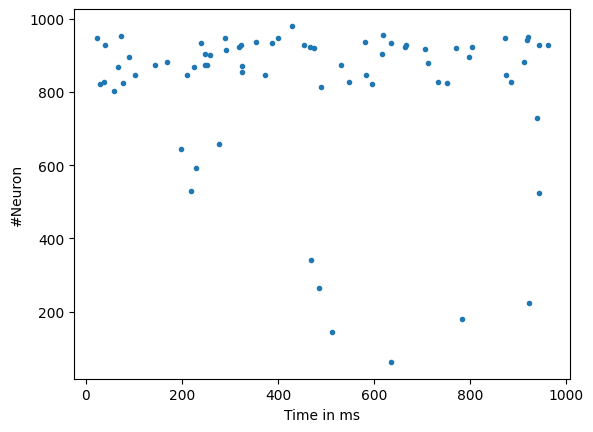

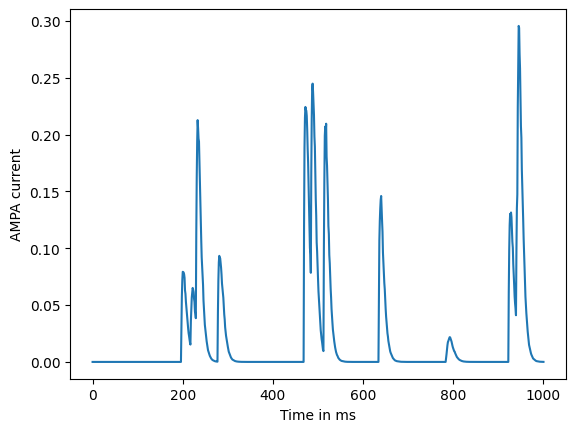

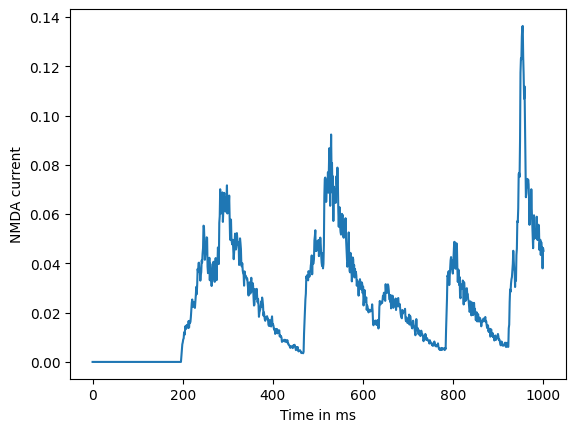

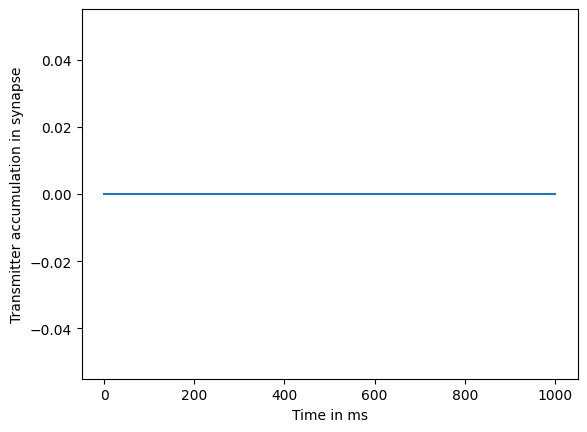

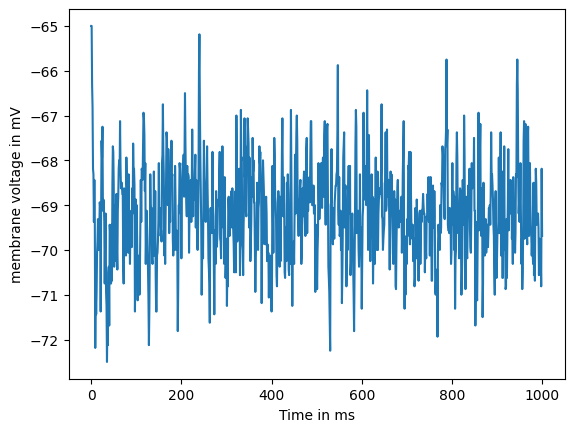

In [330]:
#Plot results

firings = np.vstack(firings)
plt.plot(firings[:, 0], firings[:, 1], '.')
plt.xlabel('Time in ms')
plt.ylabel('#Neuron')
plt.figure()
plt.plot(AMPA_conductances[:,30])
plt.xlabel('Time in ms')
plt.ylabel('AMPA current')
plt.figure()
plt.plot(NMDA_conductances[:,50])
plt.xlabel('Time in ms')
plt.ylabel('NMDA current')
plt.figure()
plt.plot(transmitter_acc_over_time[:,808])
plt.xlabel('Time in ms')
plt.ylabel('Transmitter accumulation in synapse')
plt.figure()
plt.plot(membrane_voltages[:,808])
plt.xlabel('Time in ms')
plt.ylabel('membrane voltage in mV')
plt.show()